In [1]:
import os 
import json
import numpy as np 
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim  # 신경망 모델과 최적화 함수
from PIL import Image
from torchvision import transforms 
from torchvision.models import efficientnet_b0  # 사전 학습된 EfficientNet 모델
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import time  # 시간을 측정하기 위한 라이브러리 추가
import seaborn as sns  # Heatmap을 위한 라이브러리 추가

global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 사용 가능 여부 확인
print(f"Using device: {device}")  # 사용 중인 디바이스 출력

# GPU 정보를 출력
if device.type == "cuda":
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"cuDNN 버전: {torch.backends.cudnn.version()}")

# 평가 함수
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dataloader), f1, cm

def evaluate_model_with_labels(model, data_loader, criterion):
    """
    Evaluate the model and compute the confusion matrix, loss, and F1 score.
    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): Data loader for evaluation.
        criterion (nn.Module): Loss function.
    Returns:
        loss (float): Average loss over the dataset.
        f1 (float): F1 score.
        cm (ndarray): Confusion matrix.
        y_true (list): True labels.
        y_pred (list): Predicted labels.
    """
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")


    return total_loss / len(data_loader), f1, cm, y_true, y_pred


# 학습 결과 시각화
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Loss 그래프
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, history['train_loss'], label='Train Loss', color='tab:blue', linestyle='-')
    ax1.plot(epochs, history['val_loss'], label='Validation Loss', color='tab:blue', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')

    # Accuracy 그래프 (Secondary Axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:orange')
    ax2.plot(epochs, history['train_accuracy'], label='Train Accuracy', color='tab:orange', linestyle='-')
    ax2.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='tab:orange', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.legend(loc='upper right')

    # Title 및 레이아웃 설정
    plt.title('Loss and Accuracy over Epochs')
    fig.tight_layout()
    plt.show()


# 모델 저장 함수
def save_model(model, path):
    """
    학습된 모델 저장.
    Args:
        model (nn.Module): 저장할 모델.
        path (str): 저장 경로.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")



# 학습 기록 저장 함수
def save_history(history, path):
    """
    학습 기록 저장.
    Args:
        history (dict): 학습 기록.
        path (str): 저장 경로.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(history, f)
    print(f"History saved to {path}")
    


# 몇 개의 테스트 데이터를 시각화**
import matplotlib.pyplot as plt

def plot_sample_images(data, labels=None, num_samples=5, title="Sample Images"):
    """
    샘플 이미지를 시각화합니다. DataLoader 또는 Dataset에서 사용 가능합니다.
    
    Args:
        data (DataLoader or Dataset): DataLoader 객체 또는 Dataset 객체.
        labels (dict, optional): Dataset에서 사용하는 이미지 경로와 매핑된 레이블 (Dataset에서만 사용).
        num_samples (int): 플로팅할 샘플 이미지의 수.
        title (str): 플롯 제목.
    """
    if isinstance(data, DataLoader):  # DataLoader인 경우
        batch = next(iter(data))
        images, labels = batch
        images, labels = images[:num_samples].cpu(), labels[:num_samples].cpu()
    elif isinstance(data, torch.utils.data.Dataset):  # Dataset인 경우
        images, labels = [], []
        for i in range(num_samples):
            image, label = data[i]
            images.append(image)
            labels.append(label)
        images = torch.stack(images)  # 이미지 리스트를 텐서로 변환
    else:
        raise ValueError("data는 DataLoader 또는 Dataset 객체여야 합니다.")

    # 플롯 생성
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i].permute(1, 2, 0).numpy()  # Tensor를 Numpy로 변환 (HWC 순서)
        img = (img * [0.20664216, 0.13796554, 0.09708431]) + [0.33032764, 0.20485981, 0.13185422]  # 역정규화
        img = np.clip(img, 0, 1)  # 픽셀 값을 [0, 1] 범위로 제한

        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {labels[i]}")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

Using device: cuda
GPU 이름: NVIDIA GeForce RTX 3090
CUDA 버전: 12.4
cuDNN 버전: 90100


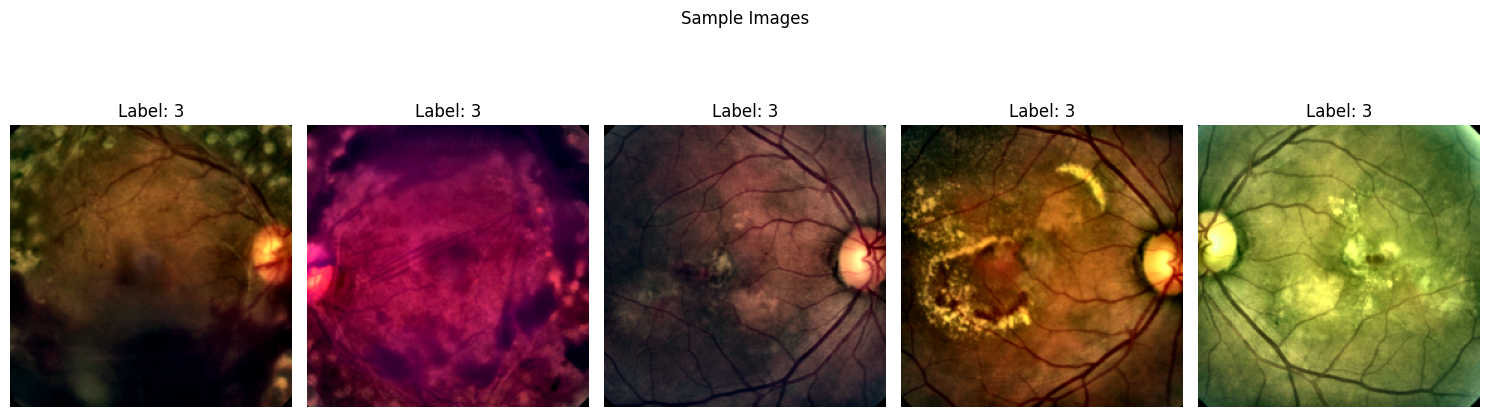

In [2]:
class FoldDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): 이미지 경로 리스트
            labels (dict): {이미지 경로: 레이블 값} 구조의 레이블
            transform (callable, optional): 이미지 전처리 파이프라인
        """
        self.image_paths = image_paths
        self.labels = [labels[path] for path in image_paths]  # 순서에 맞춘 레이블 리스트
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]  # 리스트에서 인덱스로 접근

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    
def transform_labels(labels):
    """
    JSON 레이블을 학습에 사용할 형식으로 변환합니다.
    0.0, 0.1, 1.0과 같은 값을 10배로 확장하여 정수로 변환합니다.
    """
    transformed_labels = {str(k): int(v * 10) for k, v in labels.items()}
    return transformed_labels

# JSON 파일 경로
json_path = Path("./combined_dataset/combined_dataset.json")

# 이미지 전처리 파이프라인 정의
# Channel-wise Mean: [0.45667753 0.28718717 0.1772754 ]
# Channel-wise Std: [0.14108666 0.11337343 0.08591818]

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # 이미지 크기 조정
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.45667753, 0.28718717, 0.1772754], std=[0.14108666, 0.11337343, 0.08591818])  # 정규화
# ])

import cv2
import numpy as np
from torchvision import transforms
from torchvision.transforms import functional as F

class ApplyCLAHE:
    """
    CLAHE (Contrast Limited Adaptive Histogram Equalization) 적용 클래스.
    펀더스 이미지의 대비를 향상시켜 더 뚜렷한 세부 정보를 제공.
    """
    def __call__(self, img):
        img = np.array(img)  # 이미지를 NumPy 배열로 변환
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # RGB 이미지를 LAB 색 공간으로 변환
        l, a, b = cv2.split(lab)  # LAB 채널 분리
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # CLAHE 생성
        cl = clahe.apply(l)  # L 채널에 CLAHE 적용
        limg = cv2.merge((cl, a, b))  # 처리된 L 채널과 기존 A, B 채널 병합
        return F.to_pil_image(cv2.cvtColor(limg, cv2.COLOR_LAB2RGB))  # 다시 RGB로 변환 후 PIL 이미지로 반환

# Channel-wise Mean: [0.45242608 0.27754296 0.16601739]
# Channel-wise Std: [0.13136276 0.09985017 0.07743429]

# 펀더스 이미지 전처리 파이프라인
transform = transforms.Compose([
    ApplyCLAHE(),  # CLAHE 적용: 대비 향상 및 세부 정보 강조
    transforms.Resize((224, 224)),  # 이미지 크기 조정: 딥러닝 모델 입력 크기에 맞춤
    # transforms.CenterCrop((224, 224)),  # 중심 크롭: 펀더스 이미지는 중심 영역이 ROI이므로 주변을 제거
    transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전: 데이터 다양성을 위해 추가 (50% 확률)
    transforms.RandomVerticalFlip(p=0.5),  # 상하 반전: 데이터 다양성 확보 (50% 확률)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    # 밝기, 대비, 채도, 색조 조정: 조명 및 색상 변화를 시뮬레이션하여 데이터 일반화
    transforms.ToTensor(),  # 이미지를 텐서(Tensor)로 변환
    transforms.Normalize(mean=[0.45242608, 0.27754296, 0.16601739], std=[0.13136276, 0.09985017, 0.07743429])
    # 정규화: RGB 채널별 평균과 표준편차를 사용하여 픽셀 값을 정규화.
    # 펀더스 이미지에서 각 채널의 값 범위를 0에 가깝게 표준화하여 안정적인 학습 유도
])
# tEST
# JSON 데이터 로드
with open(json_path, "r") as f:
    data = json.load(f)
    
# labels = data.get("labels", {})
labels = transform_labels(data["labels"])

# 테스트 데이터 분리
test_paths = data.get("test", [])
test_dataset = FoldDataset(test_paths, labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 샘플 이미지 플로팅 호출**
plot_sample_images(test_dataset, labels, num_samples=5)

In [3]:
# Fold별 DataLoader 생성
fold_loaders = {}
for fold_name, fold_data in data.get("folds", {}).items():
    train_paths = fold_data.get("train", [])
    val_paths = fold_data.get("val", [])

    train_dataset = FoldDataset(train_paths, labels, transform=transform)
    val_dataset = FoldDataset(val_paths, labels, transform=transform)

    fold_loaders[fold_name] = {
        "train": DataLoader(train_dataset, batch_size=32, shuffle=True),
        "val": DataLoader(val_dataset, batch_size=32, shuffle=False)
    }

# 학습 기록 초기화
history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

num_epochs = 50
batch_size = 32

# labels 값이 문자열이라면 변환
unique_labels = set(map(float, labels.values()))
num_classes = len(unique_labels)

# num_classes = 11

best_test_accuracy = 0.0
best_model_path = "./va_models/va_classifier_v1.pth"  # 모델 저장 경로
# model_save_path = "./models/va_classifier_v1.pth"  # 모델 저장 경로
history_save_path = "./history/history.json"  # 학습 기록 저장 경로

print(num_classes)

criterion = nn.CrossEntropyLoss()

11


------
# VIT 모델
------

/home/jin/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training Fold: fold_0
New best Val Accuracy: 16.51% (Previous: 0.00%)
Best model saved to best_epoch_model.pth
Epoch [1/50], Time: 235.69s, Train Accuracy: 16.10%, Val Accuracy: 16.51%, F1 Score: 0.1425
New best Val Accuracy: 18.65% (Previous: 16.51%)
Best model saved to best_epoch_model.pth
Epoch [2/50], Time: 226.80s, Train Accuracy: 18.44%, Val Accuracy: 18.65%, F1 Score: 0.1626
Epoch [3/50], Time: 193.78s, Train Accuracy: 19.19%, Val Accuracy: 15.71%, F1 Score: 0.1320
Epoch [4/50], Time: 193.49s, Train Accuracy: 19.31%, Val Accuracy: 14.88%, F1 Score: 0.1164
Epoch [5/50], Time: 194.91s, Train Accuracy: 19.64%, Val Accuracy: 16.15%, F1 Score: 0.1290
Epoch [6/50], Time: 193.61s, Train Accuracy: 21.23%, Val Accuracy: 16.84%, F1 Score: 0.1407
Epoch [7/50], Time: 193.23s, Train Accuracy: 21.82%, Val Accuracy: 16.94%, F1 Score: 0.1470
Epoch [8/50], Time: 192.88s, Train Accuracy: 21.71%, Val Accuracy: 17.42%, F1 Score: 0.1522
Epoch [9/50], Time: 193.34s, Train Accuracy: 21.64%, Val Accur

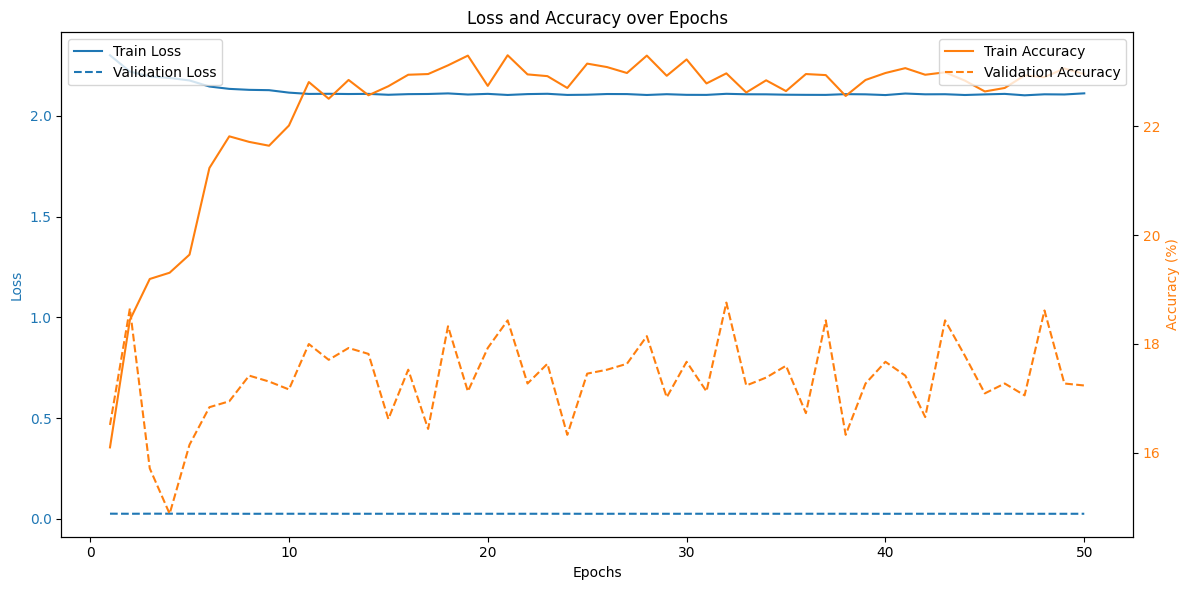

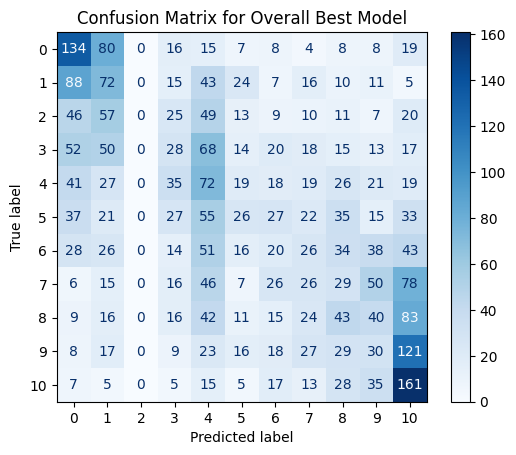

In [4]:
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import torch
import time
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


vit_model_ver = "vit_base_patch16_224"
# Vision Transformer 모델 생성 함수
def create_vit_model(num_classes, version="vit_base_patch16_224"):
    """
    Create Vision Transformer (ViT) model with an enhanced classifier for transfer learning.
    Args:
        num_classes (int): Output class count.
        version (str): ViT version, e.g., "vit_base_patch16_224".
    Returns:
        model (nn.Module): Vision Transformer model.
    """
    model = create_model(version, pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all pre-trained layers

    in_features = model.head.in_features
    model.head = nn.Sequential(
        nn.Linear(in_features, in_features // 2),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features // 2, in_features // 4),
        nn.ReLU(),
        nn.BatchNorm1d(in_features // 4),
        nn.Linear(in_features // 4, num_classes)
    )
    return model

# 최적 모델 저장 및 불러오기
def save_best_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Best model saved to {path}")

def load_best_model(model, path):
    model.load_state_dict(torch.load(path))
    print(f"Best model loaded from {path}")
    return model

overall_start_time = time.time()
# --- Fold 학습 루프 ---
best_overall_accuracy = 0.0
overall_best_model_path = ".\best_va_model\best_vit_model_overall.pth"

for fold_name, loaders in fold_loaders.items():
    print(f"\nTraining Fold: {fold_name}")

    # 레이블 초기화
    labels = {}
    for k, v in data["labels"].items():
        labels[str(k)] = int(v * 10)

    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    best_fold_accuracy = 0.0
    fold_best_model_path = f"best_vit_model_{fold_name}.pth"

    train_loader = loaders["train"]
    val_loader = loaders["val"]

    model = create_vit_model(num_classes, version=vit_model_ver).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels_batch in train_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()

        train_accuracy = 100 * correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_accuracy'].append(train_accuracy)

        val_loss, f1, cm = evaluate_model(model, val_loader, criterion)
        val_accuracy = 100 * cm.diagonal().sum() / cm.sum()
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            print(f"New best Val Accuracy: {val_accuracy:.2f}% (Previous: {best_val_accuracy:.2f}%)")
            best_val_accuracy = val_accuracy
            save_best_model(model, "best_epoch_model.pth")

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Time: {epoch_time:.2f}s, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Accuracy: {val_accuracy:.2f}%, F1 Score: {f1:.4f}")

        scheduler.step()

    print(f"\nLoading the best model for Fold {fold_name}...")
    best_model = create_vit_model(num_classes, version=vit_model_ver).to(device)
    best_model = load_best_model(best_model, "best_epoch_model.pth")

    best_model.eval()
    test_loss, f1, cm = evaluate_model(best_model, test_loader, criterion)
    fold_test_accuracy = 100 * cm.diagonal().sum() / cm.sum()
    print(f"Fold Test Loss: {test_loss:.4f}, Test Accuracy: {fold_test_accuracy:.2f}%, F1 Score: {f1:.4f}")

    if fold_test_accuracy > best_fold_accuracy:
        print(f"New best Fold Test Accuracy: {fold_test_accuracy:.2f}% (Previous: {best_fold_accuracy:.2f}%)")
        best_fold_accuracy = fold_test_accuracy
        save_best_model(best_model, fold_best_model_path)

    if fold_test_accuracy > best_overall_accuracy:
        print(f"New overall best Test Accuracy: {fold_test_accuracy:.2f}% (Previous: {best_overall_accuracy:.2f}%)")
        best_overall_accuracy = fold_test_accuracy
        save_best_model(best_model, overall_best_model_path)
        
overall_end_time = time.time()
overall_train_time = overall_end_time - overall_start_time

# --- Final Evaluation ---
print(f"\nLoading the overall best model for final testing...")
final_best_model = create_vit_model(num_classes, version=vit_model_ver).to(device)
final_best_model = load_best_model(final_best_model, overall_best_model_path)

final_best_model.eval()
final_test_loss, final_f1, final_cm, y_true, y_pred = evaluate_model_with_labels(final_best_model, test_loader, criterion)
final_test_accuracy = 100 * final_cm.diagonal().sum() / final_cm.sum()

print(f"Final Test Loss: {final_test_loss:.4f},  Total Train Time: {overall_train_time:.2f}s, Test Accuracy: {final_test_accuracy:.2f}%, F1 Score: {final_f1:.4f}")

# --- 결과 시각화 ---
plot_metrics(history)  # Plot accuracy and loss

# 실제 레이블 사용한 혼동 행렬 시각화
actual_classes = sorted(set(y_true))  # 실제 레이블에서 고유 클래스 추출
num_actual_classes = len(actual_classes)

if final_cm.shape[0] != num_actual_classes:
    print("Adjusting confusion matrix size...")
    adjusted_cm = np.zeros((num_actual_classes, num_actual_classes), dtype=int)
    for i, actual_class in enumerate(actual_classes):
        for j, predicted_class in enumerate(actual_classes):
            if actual_class in range(final_cm.shape[0]) and predicted_class in range(final_cm.shape[1]):
                adjusted_cm[i, j] = final_cm[actual_class, predicted_class]
    final_cm = adjusted_cm

disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=actual_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Overall Best Model")
plt.show()


# EfficientNet 
위 코드는 **EfficientNet-B4** 모델을 사용하여 **K-Fold Cross-Validation**를 수행하는 딥러닝 학습 파이프라인입니다. 모델의 성능을 개선하고 검증하며, 각 단계에서 최적의 모델을 저장하고 평가할 수 있도록 설계되었습니다. Epoch 단위, Fold 단위, 전체 Fold 단위에서 최적 모델을 관리하며, 최종적으로 test 데이터를 사용해 모델의 최종 성능을 평가합니다.

---

### 주요 특징

1. **EfficientNet 모델 활용**:
   - EfficientNet-B4 모델을 사용하며, 분류 계층(classifier)을 강화하여 학습 성능을 높임.
   - Transfer learning을 통해 사전 학습된 모델을 기반으로 함.

2. **Epoch 단위 검증**:
   - Epoch 단위에서 **validation accuracy**를 기준으로 최적의 모델을 저장 (`best_epoch_model.pth`).
   - Validation 데이터를 활용하여 학습 과정 중 모델 성능을 지속적으로 모니터링.

3. **Fold 단위 최적화**:
   - 각 Fold에서의 최적 모델(`best_fold_model_fold_X.pth`)을 test 데이터로 평가.
   - Fold 단위에서의 최적 모델과 전체 Fold 단위 최적 모델을 비교.

4. **전체 Fold 단위 평가**:
   - 모든 Fold가 종료된 후, 가장 성능이 우수한 모델(`best_model_overall.pth`)을 최종적으로 선정.
   - Test 데이터로 최종 평가를 수행하여, Confusion Matrix와 Accuracy/Loss 그래프를 시각화.

5. **데이터 분할 및 역할**:
   - Validation 데이터: Epoch 단위 모델 검증에 사용.
   - Test 데이터: Fold 단위 및 최종 평가에 사용.

6. **모델 저장 및 로드**:
   - Epoch, Fold, 전체 Fold 단위의 최적 모델을 저장 및 로드하는 함수 제공 (`save_best_model`, `load_best_model`).

7. **시각화**:
   - Confusion Matrix와 Train/Validation Accuracy 및 Loss 그래프를 하나의 플롯에 시각화.
   - 학습 및 평가 과정을 명확히 파악할 수 있도록 함.

---

### 코드의 장점
- **효율적인 모델 관리**: Epoch, Fold, 전체 Fold 단위에서 최적 모델을 지속적으로 관리.
- **종합적인 평가**: 학습 중 validation 데이터를 활용, Fold 종료 시 test 데이터를 사용해 성능 검증.
- **재현성**: 최적의 모델을 저장하여 이후 실험에서 다시 사용 가능.
- **시각화**: 학습 및 평가 결과를 직관적으로 이해할 수 있도록 시각화.

In [ ]:
# EfficientNet-B4 모델 생성 함수
from timm import create_model
import torch.nn as nn
import torch
import time
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# 최적 모델 저장 및 불러오기
def save_best_model(model, path):
    torch.save(model.state_dict(), path)  # Save model weights
    print(f"Best model saved to {path}")

def load_best_model(model, path):
    model.load_state_dict(torch.load(path))  # Load saved model weights
    print(f"Best model loaded from {path}")
    return model

def create_efficientnet_model(num_classes, version="efficientnet_b4"):
    """
    Create EfficientNet model with an enhanced classifier for transfer learning.
    Args:
        num_classes (int): Output class count.
        version (str): EfficientNet version, e.g., "efficientnet_b4".
    Returns:
        model (nn.Module): EfficientNet model.
    """
    model = create_model(version, pretrained=True)  # Load pretrained EfficientNet
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers except the classifier

    # Replace the classifier layer with an enhanced architecture
    in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, in_features // 2),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features // 2, in_features // 4),
        nn.ReLU(),
        nn.BatchNorm1d(in_features // 4),
        nn.Linear(in_features // 4, num_classes)
    )
    return model

# 평가 함수 수정: 예측값과 실제 레이블 반환
def evaluate_model_with_labels(model, data_loader, criterion):
    """
    Evaluate the model and compute the confusion matrix, loss, and F1 score.
    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): Data loader for evaluation.
        criterion (nn.Module): Loss function.
    Returns:
        loss (float): Average loss over the dataset.
        f1 (float): F1 score.
        cm (ndarray): Confusion matrix.
        y_true (list): True labels.
        y_pred (list): Predicted labels.
    """
    model.eval()
    total_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    return total_loss / len(data_loader), f1, cm, y_true, y_pred

overall_start_time = time.time()
# Fold 학습 루프
best_overall_accuracy = 0.0  # 전체 Fold 중 가장 높은 성능
overall_best_model_path = "best_model_overall.pth"  # 전체 최적 모델 경로

for fold_name, loaders in fold_loaders.items():
    print(f"\nTraining Fold: {fold_name}")

    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_fold_accuracy = 0.0
    fold_best_model_path = f"best_model_fold_{fold_name}.pth"

    train_loader = loaders["train"]
    val_loader = loaders["val"]

    model = create_efficientnet_model(num_classes, version="efficientnet_b4").to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_accuracy'].append(train_accuracy)

        val_loss, f1, cm = evaluate_model_with_labels(model, val_loader, criterion)[:3]
        val_accuracy = 100 * cm.diagonal().sum() / cm.sum()
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_best_model(model, "best_epoch_model.pth")

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Time: {epoch_time:.2f}s, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Accuracy: {val_accuracy:.2f}%, F1 Score: {f1:.4f}")

    print(f"\nLoading the best model for Fold {fold_name}...")
    best_model = create_efficientnet_model(num_classes, version="efficientnet_b4").to(device)
    best_model = load_best_model(best_model, "best_epoch_model.pth")

    test_loss, f1, cm, y_true, y_pred = evaluate_model_with_labels(best_model, test_loader, criterion)
    fold_test_accuracy = 100 * cm.diagonal().sum() / cm.sum()
    print(f"Fold Test Loss: {test_loss:.4f}, Test Accuracy: {fold_test_accuracy:.2f}%, F1 Score: {f1:.4f}")

    if fold_test_accuracy > best_fold_accuracy:
        best_fold_accuracy = fold_test_accuracy
        save_best_model(best_model, fold_best_model_path)

    if fold_test_accuracy > best_overall_accuracy:
        best_overall_accuracy = fold_test_accuracy
        save_best_model(best_model, overall_best_model_path)

overall_end_time = time.time()
overall_train_time = overall_end_time - overall_start_time

# 최종 모델 평가
final_best_model = create_efficientnet_model(num_classes, version="efficientnet_b4").to(device)
final_best_model = load_best_model(final_best_model, overall_best_model_path)

final_test_loss, final_f1, final_cm, y_true, y_pred = evaluate_model_with_labels(final_best_model, test_loader, criterion)
final_test_accuracy = 100 * final_cm.diagonal().sum() / final_cm.sum()

print(f"Final Test Loss: {final_test_loss:.4f}, Total Train Time: {overall_train_time:.2f}s, Test Accuracy: {final_test_accuracy:.2f}%, F1 Score: {final_f1:.4f}")

# --- 결과 시각화 ---
plot_metrics(history)  # Plot accuracy and loss

actual_classes = sorted(set(y_true))
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=actual_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Overall Best Model")
plt.show()


------
# Xception Models

------

In [ ]:
from timm import create_model as timm_create_model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import time

# 모델 생성 함수
def create_xception_model(num_classes):
    """
    Create Xception model with an enhanced classifier for transfer learning.
    Args:
        num_classes (int): Number of output classes.
    Returns:
        model (nn.Module): Xception model with enhanced classifier.
    """
    model = timm_create_model('xception', pretrained=True)

    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers

    in_features = model.fc.in_features

    model.fc = nn.Sequential(
        nn.Linear(in_features, in_features // 2),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features // 2, in_features // 4),
        nn.ReLU(),
        nn.BatchNorm1d(in_features // 4),
        nn.Dropout(0.3),
        nn.Linear(in_features // 4, num_classes)
    )

    for param in model.fc.parameters():
        param.requires_grad = True  # Train only the classifier

    return model

# 최적 모델 저장 및 불러오기
def save_best_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Best model saved to {path}")

def load_best_model(model, path):
    model.load_state_dict(torch.load(path))
    print(f"Best model loaded from {path}")
    return model

overall_start_time = time.time()
# --- Fold 학습 루프 ---
best_overall_accuracy = 0.0
overall_best_model_path = "best_xception_model_overall.pth"

for fold_name, loaders in fold_loaders.items():
    print(f"\nTraining Fold: {fold_name}")

    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
    best_fold_accuracy = 0.0
    fold_best_model_path = f"best_xception_model_{fold_name}.pth"

    train_loader = loaders["train"]
    val_loader = loaders["val"]

    model = create_xception_model(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_accuracy = 0.0

    # Epoch 학습
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels_batch in train_loader:
            images, labels_batch = images.to(device), labels_batch.to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()

        train_accuracy = 100 * correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_accuracy'].append(train_accuracy)

        val_loss, f1, cm = evaluate_model_with_labels(model, val_loader, criterion)[:3]
        val_accuracy = 100 * cm.diagonal().sum() / cm.sum()
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_best_model(model, "best_epoch_model.pth")

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Time: {epoch_time:.2f}s, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Accuracy: {val_accuracy:.2f}%, F1 Score: {f1:.4f}")

        scheduler.step()

    print(f"\nLoading the best model for Fold {fold_name}...")
    best_model = create_xception_model(num_classes).to(device)
    best_model = load_best_model(best_model, "best_epoch_model.pth")

    test_loss, f1, cm, y_true, y_pred = evaluate_model_with_labels(best_model, test_loader, criterion)
    fold_test_accuracy = 100 * cm.diagonal().sum() / cm.sum()
    print(f"Fold Test Loss: {test_loss:.4f}, Test Accuracy: {fold_test_accuracy:.2f}%, F1 Score: {f1:.4f}")

    if fold_test_accuracy > best_fold_accuracy:
        best_fold_accuracy = fold_test_accuracy
        save_best_model(best_model, fold_best_model_path)

    if fold_test_accuracy > best_overall_accuracy:
        best_overall_accuracy = fold_test_accuracy
        save_best_model(best_model, overall_best_model_path)

overall_end_time = time.time()
overall_train_time = overall_end_time - overall_start_time

# 최종 모델 평가
final_best_model = create_xception_model(num_classes).to(device)
final_best_model = load_best_model(final_best_model, overall_best_model_path)

final_test_loss, final_f1, final_cm, y_true, y_pred = evaluate_model_with_labels(final_best_model, test_loader, criterion)
final_test_accuracy = 100 * final_cm.diagonal().sum() / final_cm.sum()

print(f"Final Test Loss: {final_test_loss:.4f}, Total Train Time: {overall_train_time:.2f}s, Test Accuracy: {final_test_accuracy:.2f}%, F1 Score: {final_f1:.4f}")


# --- 결과 시각화 ---
plot_metrics(history)  # Plot accuracy and loss

actual_classes = sorted(set(y_true))
print("actual_classes", actual_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=actual_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Overall Best Model")
plt.show()
